# ADC Calibration

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pyvisa as visa
from pathlib import Path
from scipy.interpolate import interp1d

from saveCalData import saveMeasurement
from progressbar import update_progress

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [130]:
def yes_or_no(question):
    reply = str(input(f'{question} (y/n):').lower().strip())
    if reply == 'y':
        return True
    elif reply == 'n':
        return False
    else:
        print('Invalid input. Not proceeding.')
        return False

In [4]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
dc205 = serial.Serial(port='COM12', baudrate=115200, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [5]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(dc205, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,DC205,s/n20500218,ver1.80
Agilent Technologies,34450A,MY52449038,00.56-00.63



In [57]:
serialCmd(dc205, 'RNGE 2')
serialCmd(dc205, 'VOLT 1.5')

In [29]:
serialCmd(dc205, 'VOLT 0.0')

In [23]:
serialCmd(dc205, 'SOUT ON')

In [30]:
serialCmd(dc205, 'SOUT OFF')

In [29]:
for i in range(0, 25):
    print(serialQry(sr542, f'$COD? 1'))
    time.sleep(0.25)

28
29
30
29
29
27
30
25
22
29
30
32
29
30
27
28
30
26
30
29
24
26
29
30
30


In [6]:
serialQry(sr542, '$ADC? 0')

'0.000000e+00, 1.000000e+00'

# Define Cal Functions

In [6]:
def twos_comp(val, bits):
    if (val & (1 << (bits - 1))) != 0: # sign bit is set
        val = val - (1 << bits)
    return val

In [238]:
class AdcChannel():
    def __init__(self, channel, differential, vmax):
        
        # 0 = VCO
        # 1 = CURR_MON
        # 2 = VOLT_MON
        # 4 = CHOP_5V_MON
        
        if channel in [0, 1, 2, 4]:
            self.channel = channel
        else:
            raise ValueError('Invalid Channel Number')                
        self.adcBits = 16
        self.differential = differential # True/False
        self.numCodes = 2**self.adcBits
        self.Vref = 3.3
        self.LSB_V = self.Vref/self.numCodes # LSB size, in Volts 
        self.vmax = vmax   
        
        self.calOffset = 0.0
        self.calSlope = 1.0  
        self.cald = False
        self.passed = False 
        
    def VoltsToCode(self, v):
        codeBits = self.adcBits if not self.differential else (self.adcBits - 1)
        return v * (2**codeBits - 1)/self.vmax
        #return (v*self.prescale + self.offset)/self.Vref * 2**codeBits            
        
    def CodeToVolts(self, c):
        codeBits = self.adcBits if not self.differential else (self.adcBits - 1)
        return c * self.vmax/(2**codeBits - 1)
        #return (c/2**codeBits * self.Vref - self.offset)/self.prescale

    def MeasCodeVsVoltage(self, voltList):
        # TODO: Add check that test voltages do not exceed self.vmax?
        serialCmd(dc205, 'VOLT 0.0')
        serialCmd(dc205, 'SOUT ON')
        t0 = time.time()

        codes = []
        for v in voltList:
            serialCmd(dc205, f'VOLT {v:.3f}')           

            time.sleep(0.5) #TODO: how long to sleep here?
            c = int(serialQry(sr542, f'$COD? {self.channel}'))
            if self.differential:
                c = twos_comp(c, self.adcBits)
            codes.append(c) 

            update_progress(len(codes) / len(voltList))

        serialCmd(dc205, 'VOLT 0.0')
        serialCmd(dc205, 'SOUT OFF')        

        print(f'elapsed time = {time.time() - t0}')

        return np.array(codes)
        
    def CalculateCal(self, voltList, measuredCodes):     
        inputCodes = self.VoltsToCode(voltList)
        coeffs, cov = np.polyfit(inputCodes, measuredCodes, 1, cov=True)
        fit = np.poly1d(coeffs)
        slope = coeffs[0]
        offset = coeffs[1]

        fig, ax = plt.subplots(2, 1, figsize=(8,8))
        ax[0].plot(voltList, measuredCodes, '.')
        ax[0].plot(voltList, fit(inputCodes))
        ax[0].set_xlabel('input voltage (V)')
        ax[0].set_ylabel('measured code (adc code)')
        
        #axTop = ax[0].secondary_xaxis('top', functions=(self.VoltsToCode, self.CodeToVolts))
        #axTop.set_xlabel('input voltage (adc code)')
        
        res = fit(inputCodes) - measuredCodes
        ax[1].plot(voltList, res, 'o-')
        ax[1].set_ylabel('fit residual (adc code)')
        
        print(f'RMS Residual Error = {rms(res):.3f} adc codes')
        
        self.calSlope = slope
        if self.differential:
            self.calOffset = offset/(2**(self.adcBits - 1) - 1)
        else:
            self.calOffset = offset/(2**self.adcBits - 1)
        self.cald = True
        
    def GetCalibratedFrac(self, measuredFrac):
        return (measuredFrac - self.calOffset)/self.calSlope
    
    def ShowCalibration(self, voltList, measuredCodes):
        codeBits = self.adcBits if not self.differential else (self.adcBits - 1)
        measuredFrac = measuredCodes/(2**codeBits - 1)
        calibratedFrac = self.GetCalibratedFrac(measuredFrac)        
        calibratedError_codes = (voltList/self.vmax - calibratedFrac)*self.numCodes
        uncalibratedError_codes = (voltList/self.vmax - measuredFrac)*self.numCodes
        
        fig, ax = plt.subplots(2, 1, figsize = (8,8))
        ax[0].plot(voltList/self.vmax, calibratedError_codes, 'o-', label='cal', color='C1')        
        ax[0].set_ylabel('calibrated error (adc code)')
        
        ax[1].plot(voltList/self.vmax, uncalibratedError_codes, '.-', label='uncal', color='C0')        
        ax[1].set_xlabel('input (frac of FS input)')
        ax[1].set_ylabel("uncal'd error (adc code)")
        
        ax[0].set_title('Expected Calibrated Error')
        ax[0].legend()
        ax[1].legend()
        
        print(f'Calibrated rms error for the tested inputs would be = {rms(calibratedError_codes):.3f} adc codes')
            
    def EvaluatePassFail(self, dacCodes, V_meas):
        pass
            
    def UploadCalData(self):
        offset, slope = serialQry(sr542, f'$ADC? {self.channel}').split(',')
        offset = float(offset)
        slope = float(slope)
        
        d_offset = (self.calOffset - offset)*self.numCodes
        d_slope = (self.calSlope - slope)/slope*100

        if (d_offset > 1 or d_slope > 1/self.numCodes*100):
            print('This will adjust the calibration of this ADC channel')
            print(f'The offset will change by {d_offset:.3e} codes')
            print(f'The slope will change by {d_slope:.3e}%')
            proceed = yes_or_no('Proceed?')
        else:
            print('The calibration is unchanged')
            print(f'd_offset = {d_offset:.3e} codes')
            print(f'd_slope = {d_slope:.3e} %')
            
        if proceed:
            serialCmd(sr542, f'$ADC {self.channel}, {self.calOffset:.6e}, {self.calSlope:.6e}')
            
    def SaveCalData(self):
        controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        saveMeasurement('.\CalData', controllerSn, f'Ch{self.channel}_adcCal', np.vstack([self.calOffset, self.calSlope]), 
                                                                                ['offset', 'slope'], fmt='%.6e')

In [239]:
Vco = AdcChannel(0, differential=True, vmax = 10.0)

In [225]:
testVolts = np.linspace(0, 10, 21)
testVolts

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [240]:
adcCodes = Vco.MeasCodeVsVoltage(testVolts)

Progress: [####################] 100.0%
elapsed time = 10.911847591400146


In [249]:
adcCodes

array([  -70,  1537,  3139,  4749,  6348,  7957,  9565, 11168, 12777,
       14378, 15985, 17590, 19199, 20804, 22407, 24013, 25619, 27225,
       28834, 30434, 32041])

In [253]:
adcCodes[0]/2**15 * Vco.Vref

-0.007049560546875

In [254]:
adcCodes[-1]/(2**15 - 1) * Vco.Vref

3.2268837549974054

RMS Residual Error = 1.855 adc codes


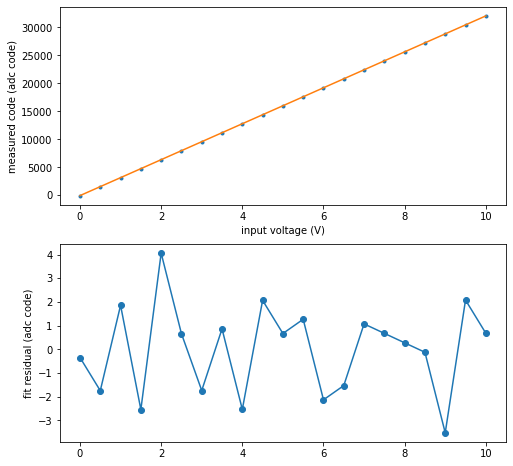

In [241]:
Vco.CalculateCal(testVolts, adcCodes)

In [242]:
print(Vco.calOffset)
print(Vco.calSlope)

-0.0021468648440905185
0.9800111689817795


Calibrated rms error for the tested inputs would be = 3.786 adc codes


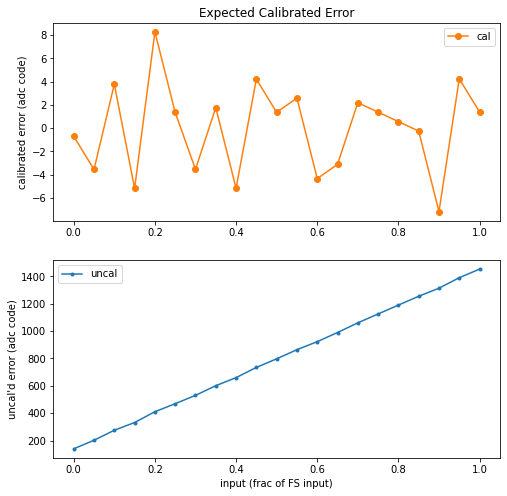

In [243]:
Vco.ApplyCalibration(testVolts, adcCodes)

In [245]:
serialQry(sr542, '$ADC? 0')

'-2.152149e-03, 9.799723e-01'

In [246]:
Vco.UploadCalData()

This will adjust the calibration of this ADC channel
The offset will change by 3.463e-01 codes
The slope will change by 3.966e-03%
Proceed? (y/n):y


In [247]:
serialQry(sr542, '$ADC? 0')

'-2.146865e-03, 9.800112e-01'

In [248]:
Vco.SaveCalData()

## How to verify the calibration?

In [43]:
serialCmd(dc205, 'SOUT ON')

In [44]:
f_src = []
for v in testVolts:
    serialCmd(dc205, f'VOLT {v:.3f}')           

    time.sleep(3.0) #TODO: how long to sleep here?
    f = float(serialQry(sr542, 'MFRQ? SRCE'))
    f_src.append(f)    

    update_progress(len(f_src) / len(testVolts))

Progress: [####################] 100.0%


In [45]:
serialCmd(dc205, 'SOUT OFF')

In [46]:
f_src

[0.0,
 5.01,
 9.99,
 15.01,
 19.99,
 25.0,
 30.01,
 35.01,
 40.02,
 45.0,
 50.01,
 55.01,
 60.01,
 65.02,
 70.01,
 75.01,
 80.01,
 85.02,
 90.01,
 95.01,
 100.0]

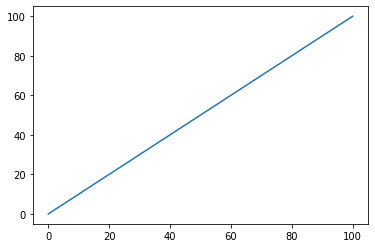

In [47]:
plt.plot(testVolts/10 * 100, f_src)

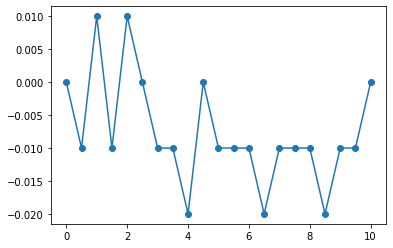

In [48]:
plt.plot(testVolts, testVolts/10 * 100 - f_src, 'o-')

In [49]:
rms(testVolts/10 * 100 - f_src)

0.011126972805283878

# Putting it all together